Shape of X_train_0: (99990, 10)
Shape of Y_train_0: (99990, 10, 2)
Shape of X_train_1: (99990, 10)
Shape of Y_train_1: (99990, 10, 2)
Shape of X_train_2: (99990, 10)
Shape of Y_train_2: (99990, 10, 2)


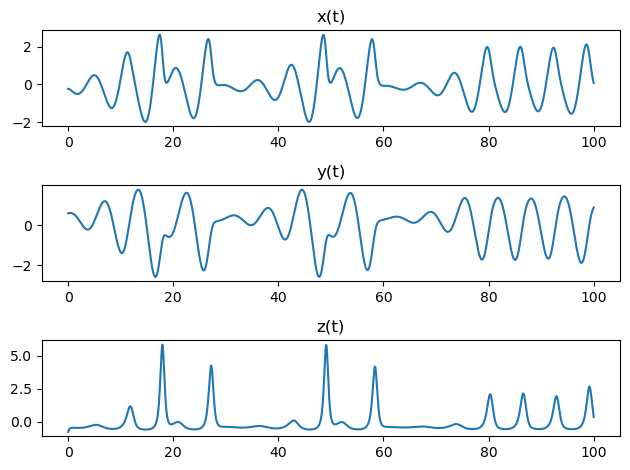

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Define the Rössler equations
def rossler(Y, a, b, c):
    x, y, z = Y
    dxdt = -y - z
    dydt = x + a * y
    dzdt = b + z * (x - c)
    return np.array([dxdt, dydt, dzdt])

# Parameters
a = 0.5
b = 2.0
c = 4.0

# Initial conditions
Y = np.array([0.1, 0, 0])

# Time step and total time
dt = 0.001
T = 100
n_steps = int(T/dt)

# Create an array to store the solution
solution = np.zeros((n_steps, 3))
solution[0] = Y

# Time grid for integration
t = np.linspace(0, T, n_steps)

# Euler's method
for i in range(1, n_steps):
    Y = Y + rossler(Y, a, b, c) * dt
    solution[i] = Y
solution = zscore(solution, axis=0)  # Normalize the solution

# Define function to create training data for reservoir computing
def create_rc_training_data_multi(solution, N):
    data = {}
    for i in range(3):  # For each coordinate (x, y, z)
        X, Y = [], []
        for j in range(len(solution) - N):
            X.append(solution[j:j+N, i])
            Y.append(np.delete(solution[j:j+N, :], i, axis=1))
        data[f"X_train_{i}"] = np.array(X)
        data[f"Y_train_{i}"] = np.array(Y)
    return data

# Create training data with sequence length N
N = 10
training_data = create_rc_training_data_multi(solution, N)

# Print shape of training data
for k, v in training_data.items():
    print(f"Shape of {k}:", v.shape)


# Plot the solution
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(t, solution[:, 0])
plt.title('x(t)')
plt.subplot(3, 1, 2)
plt.plot(t, solution[:, 1])
plt.title('y(t)')
plt.subplot(3, 1, 3)
plt.plot(t, solution[:, 2])
plt.title('z(t)')
plt.tight_layout()
plt.show()


In [ ]:
def tanh_vector(x):
    return np.tanh(x)

def train_reservoir(A, Win, u_train, target, dt=1, a=0.1, transient_time=0, beta=0.01):
    N = A.shape[0]
    T = u_train.shape[1]
    r = np.zeros((N, 1))
    r_states = []
    
    # Transient time adjustment
    for t in range(-transient_time, 0):
        u_t = np.zeros((u_train.shape[0], 1))
        r = (1 - a) * r + a * np.tanh(np.dot(A, r) + np.dot(Win, u_t))
    
    # Reservoir Dynamics
    for t in range(T):
        u_t = u_train[:, t].reshape(-1, 1)
        r = (1 - a) * r + a * np.tanh(np.dot(A, r) + np.dot(Win, u_t))
        r_states.append(r)
    
    r_states = np.hstack(r_states)[:, transient_time:]
    target = target[:, transient_time:]

    # Ridge Regression
    Wout = np.linalg.inv(r_states.dot(r_states.T) + beta * np.identity(N)).dot(r_states).dot(target.T)
    target_swapped = np.swapaxes(target, 1, 2)  # Now shape would be (10, 2, 99990)
    c = np.mean(target_swapped - np.dot(Wout.T, r_states))

    return Wout, c

def predict(A, Win, Wout, u_test, dt=1, a=0.1):
    N = A.shape[0]
    T = u_test.shape[1]
    r = np.zeros((N, 1))
    predicted_output = np.zeros((Wout.shape[1], T))
    for t in range(T):
        u_t = u_test[:, t].reshape(-1, 1)
        r = (1 - a) * r + a * tanh_vector(np.dot(A, r) + np.dot(Win, u_t))
        predicted_output[:, t] = np.dot(Wout.T, r).flatten()
    return predicted_output

# Parameters
N = 100  # Number of reservoir nodes
M = 10  # Number of input nodes
P = 2  # Number of output nodes

# Initialize A and Win randomly
A = np.random.uniform(-1, 1, (N, N))
Win = np.random.uniform(-0.5, 0.5, (N, M))

# Normalize A's spectral radius to less than 1
rho = np.max(np.abs(np.linalg.eigvals(A)))
A *= 1 / rho

# Example time series data
# Reshape X_train_i and Y_train_i
reshaped_X_train_0 = training_data['X_train_0'].T
reshaped_Y_train_0 = np.swapaxes(training_data['Y_train_0'], 0, 1)  

# Train the reservoir
Wout, _ = train_reservoir(A, Win, reshaped_X_train_0, reshaped_Y_train_0)

# Predict
u_test = np.sin(np.linspace(10, 20, 100)).reshape(1, -1)  # new input data
predicted_output = predict(A, Win, Wout, u_test)

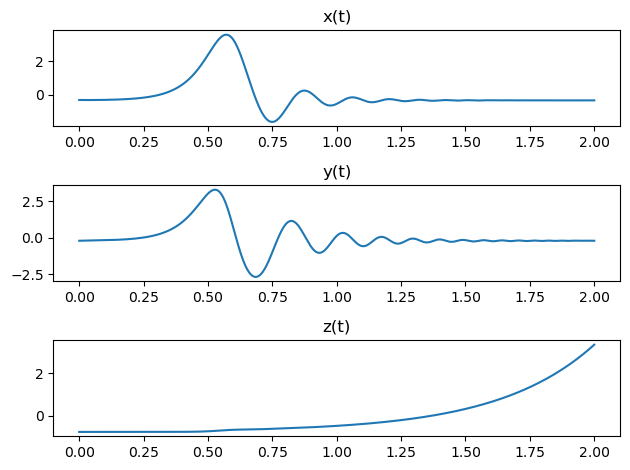

Shape of X_train_0: (1990, 10)
Shape of Y_train_0: (1990, 10, 2)
Shape of X_train_1: (1990, 10)
Shape of Y_train_1: (1990, 10, 2)
Shape of X_train_2: (1990, 10)
Shape of Y_train_2: (1990, 10, 2)


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the Lorenz equations
def lorenz(Y, t, a, b, c):
    x, y, z = Y
    dxdt = -a * x + a * y
    dydt = b * x - y - x * z
    dzdt = c * z + x * y
    return [dxdt, dydt, dzdt]

# Parameters
a = 10.0
b = 28.0
c = 8.0/3.0

# Initial conditions
Y = np.array([0.1, 0.0, 0.0])

# Time step and total time
dt = 0.001
T = 2
n_steps = int(T/dt)

# Time grid for integration
t = np.linspace(0, T, n_steps)

# Solve the differential equations using odeint
solution_lorenz = odeint(lorenz, Y, t, args=(a, b, c))
solution_lorenz = zscore(solution_lorenz, axis=0)  # Normalize the solution

# Plot the solution
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(t, solution_lorenz[:, 0])
plt.title('x(t)')
plt.subplot(3, 1, 2)
plt.plot(t, solution_lorenz[:, 1])
plt.title('y(t)')
plt.subplot(3, 1, 3)
plt.plot(t, solution_lorenz[:, 2])
plt.title('z(t)')
plt.tight_layout()
plt.show()

# Define function to create training data for reservoir computing
def create_rc_training_data_multi_lorenz(solution, N):
    data = {}
    for i in range(3):  # For each coordinate (x, y, z)
        X, Y = [], []
        for j in range(len(solution) - N):
            X.append(solution[j:j+N, i])
            Y.append(np.delete(solution[j:j+N, :], i, axis=1))
        data[f"X_train_{i}"] = np.array(X)
        data[f"Y_train_{i}"] = np.array(Y)
    return data

# Create training data with sequence length N
N = 10
training_data_lorenz = create_rc_training_data_multi_lorenz(solution_lorenz, N)

# Print shape of training data
for k, v in training_data_lorenz.items():
    print(f"Shape of {k}:", v.shape)

